# Libraries and Google Drive

In [1]:
pip install owslib rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.1/221.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 42.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd

from owslib.wms import WebMapService
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display
from IPython.display import Image as displayImage

import io
from io import BytesIO
import time
import random
import os

import rasterio
from rasterio.transform import from_bounds
from rasterio.plot import show
from rasterio.crs import CRS
import rasterio.features
from rasterio.features import geometry_mask

import shapely
from shapely.geometry import Polygon, LineString

from pyproj import Geod
from pyproj import Transformer
from geopy.distance import distance

import math

In [3]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Import csv of correctly labelled service stations and extract associated polygons

In [4]:
# Load verified_service_stations csv and transform to list
verified_service_stations_path = '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/verified_service_stations.csv'

# Read the CSV file into a pandas DataFrame
verified_service_stations = pd.read_csv(verified_service_stations_path)

# Transform df to list
verified_service_stations_list = []
for row in verified_service_stations.values.tolist():
    verified_service_stations_list.extend(row)

# Print first 5 items
print("Sample list output:", verified_service_stations[:5])
print("\n")
print("Number of correctly labelled service stations:", len(verified_service_stations_list))

Sample list output:                          id_rest
0   lon_8.6630029_lat_50.2542348
1  lon_11.3531491_lat_50.9378362
2   lon_9.6300119_lat_53.8303266
3   lon_9.6297338_lat_53.8301666
4  lon_11.0102562_lat_50.8353109


Number of correctly labelled service stations: 267


In [5]:
# Load the GeoJSON files containing service station polygons and truck/car parking polygons together with service station IDs (created in 01a_OSM_rest_stops.ipynb)
all_parkings = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/OSM GeoJSON/all_parkings.geojson") # polygons of car and truck parking space
rest_stations = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/OSM GeoJSON/rest_stations.geojson") # polygons and ids of rest stations

In [6]:
# Create geopandas geodataframes that only contain polygons of correctly labelled service stations

print("Shape of all_parkings before dropping irrelevant rows:", all_parkings.shape)
print("Shape of rest_stations before dropping irrelevant rows:", rest_stations.shape)

# Drop all rows not corresponding to correctly labelled service stations
parking_areas_ver = all_parkings[all_parkings["id_rest"].isin(verified_service_stations_list)] # renamed variable!
rest_stations_ver = rest_stations[rest_stations["id"].isin(verified_service_stations_list)]

print("Shape of parking_areas_ver:", parking_areas_ver.shape)
print("Shape of rest_stations after dropping irrelevant rows:", rest_stations_ver.shape)

Shape of all_parkings before dropping irrelevant rows: (1606, 6)
Shape of rest_stations before dropping irrelevant rows: (506, 5)
Shape of parking_areas_ver: (1190, 6)
Shape of rest_stations after dropping irrelevant rows: (267, 5)


In [7]:
# Drop irrelevant columns, reorder columns, reset index of parkings_areas_ver

parking_areas_ver = parking_areas_ver.drop(["id_car", "name"], axis = 1)
parking_areas_ver = parking_areas_ver.rename(columns={"@id": "id_OSM_parking"})
parking_areas_ver = parking_areas_ver.reindex(columns=["id_rest", "id_OSM_parking", "type", "geometry"])
parking_areas_ver = parking_areas_ver.reset_index(drop = True)

parking_areas_ver.head()

,id_rest,id_OSM_parking,type,geometry
0,lon_7.5846163_lat_53.2588511,way/33526884,car,"POLYGON ((7.58527 53.25883, 7.58618 53.25869, ..."
1,lon_7.2005154_lat_52.2816225,way/38125314,car,"POLYGON ((7.19685 52.28128, 7.19692 52.28127, ..."
2,lon_10.7306355_lat_50.559048,way/48905621,car,"POLYGON ((10.73083 50.55915, 10.73087 50.55881..."
3,lon_10.7298729_lat_50.5605634,way/48925325,car,"POLYGON ((10.72986 50.56033, 10.72980 50.56026..."
4,lon_13.9503161_lat_52.3112817,way/65260801,car,"POLYGON ((13.95364 52.31074, 13.95274 52.31075..."


In [8]:
# Drop irrelevant columns, reorder columns, reset index of rest_stations_ver

rest_stations_ver = rest_stations_ver.rename(columns={"id": "id_rest", "@id": "id_OSM_rest"})
rest_stations_ver = rest_stations_ver.drop("highway", axis = 1)
rest_stations_ver = rest_stations_ver.reset_index(drop = True)

rest_stations_ver.head()

,id_rest,id_OSM_rest,name,geometry
0,lon_8.6630029_lat_50.2542348,way/22568867,Schäferborn,"POLYGON ((8.66300 50.25423, 8.66302 50.25237, ..."
1,lon_11.3531491_lat_50.9378362,way/27549694,Habichtsfang,"POLYGON ((11.35315 50.93784, 11.35315 50.93783..."
2,lon_9.6300119_lat_53.8303266,way/31128689,Steinburg,"POLYGON ((9.63001 53.83033, 9.63273 53.82905, ..."
3,lon_9.6297338_lat_53.8301666,way/31128716,Steinburg,"POLYGON ((9.62973 53.83017, 9.62965 53.83010, ..."
4,lon_11.0102562_lat_50.8353109,way/32489728,Dornheimer Rieth,"POLYGON ((11.01026 50.83531, 11.01145 50.83591..."


In [9]:
# Check shapes of dataframes

print("Shape of parking_areas_ver:", parking_areas_ver.shape)
print("Shape of rest_stations after dropping irrelevant rows:", rest_stations_ver.shape)

Shape of parking_areas_ver: (1190, 4)
Shape of rest_stations after dropping irrelevant rows: (267, 4)


In [10]:
# Download geopandas geodataframes as GeoJSONs

# Specify the path where you want to save the GeoJSON file
#output_path_parking_areas_ver = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/parking_areas_ver.geojson"
#output_path_rest_stations_ver = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/rest_stations_ver.geojson"

# Export the GeoPandas DataFrame to GeoJSON
#parking_areas_ver.to_file(output_path_parking_areas_ver, driver='GeoJSON')
#rest_stations_ver.to_file(output_path_rest_stations_ver, driver='GeoJSON')

# Load GeoJSONs and define bounding boxes for download

In [10]:
# Load the GeoJSON files of verified rest stops
parking_areas_ver = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/parking_areas_ver.geojson") # polygons of verified car and truck parking space
rest_stations_ver = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/rest_stations_ver.geojson") # polygons of verified rest stops

### Find minimum needed image size (pixels) to show maximum resolution

In [11]:
def find_biggest_rest_station(geodataframe):
    """
    Returns the biggest rest station.

    Parameters:
    geodataframe (geopandas geodataframe): contains polygon/multipolygon geometries

    Returns:
    The id of the biggest rest station.
    """

    def polygon_to_bbox(polygon):
        """
        Transforms a polygon into a square bounding box.

        Parameters:
        polygon (Polygon): input polygon

        Returns:
        The resulting square bounding box bounds as a list: [left, bottom, right, top].
        """


        # Calculate the bounding box of the polygon
        minx, miny, maxx, maxy = polygon.bounds
        bbox = [minx, miny, maxx, maxy]

        return bbox

    # Initialize variables
    max_span_overall = 0
    biggest_rest_station = None
    biggest_rest_station_bbox = None
    biggest_rest_station_name = None

    # Loop over all rows in the df, calculate the bbox and find the largest span
    for index, row in geodataframe.iterrows():
        bbox = polygon_to_bbox(row["geometry"])
        minx, miny, maxx, maxy = bbox
        x_span = maxx - minx
        y_span = maxy - miny

        max_span = max(x_span, y_span)

        if max_span > max_span_overall:
            max_span_overall = max_span
            biggest_rest_station = row["id_rest"]
            biggest_rest_station_bbox = [minx, miny, maxx, maxy]
            biggest_rest_station_name = row["name"]

    print(f"The biggest rest station is {biggest_rest_station_name} (id: {biggest_rest_station}) with a maximum bounding box span of {max_span_overall}")

    return biggest_rest_station

In [12]:
def calculate_bbox_dimensions(polygon):
    """
    Calculates the dimensions of the bounding box of a polygon in degrees.

    Parameters:
    polygon (Polygon): input polygon

    Returns:
    Width and height of the bounding box in degrees.
    """
    # Get the bounds of the polygon
    minx, miny, maxx, maxy = polygon.bounds
    # Calculate width and height in degrees
    width = maxx - minx
    height = maxy - miny
    return width, height

In [13]:
rest_station_id = find_biggest_rest_station(rest_stations_ver)

The biggest rest station is Bentheimer Wald (id: lon_7.0388979_lat_52.3124962) with a maximum bounding box span of 0.00811549999999972


In [14]:
rest_station_id_height = rest_stations_ver[rest_stations_ver["id_rest"] == "lon_7.0388979_lat_52.3124962"]["geometry"].values[0]
print(rest_station_id_height)

POLYGON ((7.0388979 52.3124962, 7.0402467 52.3117209, 7.0470134 52.313444, 7.0462468 52.3142967, 7.043728 52.313585, 7.0435905 52.3134762, 7.0388979 52.3124962))


The conversion from coordinate distance to a distance in meters is taken from this [stackexchange](https://gis.stackexchange.com/questions/403637/convert-distance-in-shapely-to-kilometres) post.

In [15]:
def find_needed_image_pixel_size(polygon, WMS_resolution = 0.2):
    minx, miny, maxx, maxy = polygon.bounds

    print("The bounding box has the following coordinates", [minx, miny, maxx, maxy])

    x_line = shapely.LineString([(minx, miny), (maxx, miny)])
    y_line = shapely.LineString([(minx, miny), (minx, maxy)])

    geod = Geod(ellps="WGS84")

    length_x = math.ceil(geod.geometry_length(x_line))
    length_y = math.ceil(geod.geometry_length(y_line))

    print(f"The bounding box has a width of: {length_x}m and a height of: {length_y}m")

    max_length = max(length_x, length_y)

    needed_resolution = math.ceil(max_length / WMS_resolution)

    print("The needed minimum pixel size is:", needed_resolution, "pixels.")

In [16]:
find_needed_image_pixel_size(rest_station_id_height)

The bounding box has the following coordinates [7.0388979, 52.3117209, 7.0470134, 52.3142967]
The bounding box has a width of: 554m and a height of: 287m
The needed minimum pixel size is: 2770 pixels.


**Findings**

*   A pixel size of more than 2770 pixels guarantees that every image of a service stop has the highest resolution possible.
*   Plan: Download images of size 600m x 600m with a pixel size of 3000





## Determine download bounding boxes


### Define function

In [17]:
def create_image_bounding_box(polygon, bbox_size_m = 600):
    """
    Create an output bounding box that fully covers the input bounding box and is of size bbox_size_m x bbox_size_m.

    Parameters:
    polygon (shapely Polygon): input polygon
    bbox_size_m (int): size of the output bounding box

    Returns:
    The output bounding box as [left, bottom, right, top]
    """

    minx, miny, maxx, maxy = polygon.bounds

    # Calculate the centre of the input bounding box
    centre_x = (miny + maxy) / 2
    centre_y = (minx + maxx) / 2

    distance_from_centre = bbox_size_m / 2

    # Calculate the coordinates distance_from_centre meters north, south, east, and west of the center
    north = distance(meters=distance_from_centre).destination((centre_x, centre_y), bearing=0).latitude
    south = distance(meters=distance_from_centre).destination((centre_x, centre_y), bearing=180).latitude
    east = distance(meters=distance_from_centre).destination((centre_x, centre_y), bearing=90).longitude
    west = distance(meters=distance_from_centre).destination((centre_x, centre_y), bearing=270).longitude

    # Calculate the maximum allowable shift in each direction to keep the input bbox within the output bbox
    max_shift_north = north - maxy
    max_shift_south = miny - south
    max_shift_east = east - maxx
    max_shift_west = minx - west

    # Randomly shift the center within the allowable range
    shift_x = random.uniform(-min(max_shift_west, distance_from_centre), min(max_shift_east, distance_from_centre))
    shift_y = random.uniform(-min(max_shift_south, distance_from_centre), min(max_shift_north, distance_from_centre))

    # Calculate the final output bounding box
    output_bbox = [
        west + shift_x,  # left
        south + shift_y, # bottom
        east + shift_x,  # right
        north + shift_y  # top
    ]

    return output_bbox

In [18]:
def determine_bbox_max_span_m(bbox):
    """
    Determine the size of a bounding box in meters.

    Parameters:
    bbox (list): bounding box as [left, bottom, right, top]
    """

    minx, miny, maxx, maxy = bbox

    x_line = shapely.LineString([(minx, miny), (maxx, miny)])
    y_line = shapely.LineString([(minx, miny), (minx, maxy)])

    geod = Geod(ellps="WGS84")

    length_x = math.ceil(geod.geometry_length(x_line))
    length_y = math.ceil(geod.geometry_length(y_line))

    print(f"The bounding box has a width of: {length_x}m and a height of: {length_y}m")

### Test function

In [19]:
# Extract random rest stop polygon

random_index = random.randint(0, 266)
print("Random index:", random_index)

# Extract polygon
test_polygon = rest_stations_ver.iloc[random_index]["geometry"]
print(test_polygon)

Random index: 194
POLYGON ((9.9397588 53.6702339, 9.9410491 53.6724436, 9.9409013 53.6724922, 9.9408258 53.6725254, 9.9397201 53.6720175, 9.9389967 53.6716852, 9.9389089 53.671271, 9.9389426 53.6711034, 9.9392269 53.6705535, 9.9392518 53.6705321, 9.9395278 53.6702959, 9.9396284 53.6702689, 9.9397588 53.6702339))


In [20]:
# Create bounding box
covering_test_bbox = create_image_bounding_box(test_polygon)
covering_test_bbox

[9.933646405274887, 53.66821773091296, 9.942724776637396, 53.67360862129795]

In [21]:
# Check bounding box size in meter
determine_bbox_max_span_m(covering_test_bbox)

The bounding box has a width of: 601m and a height of: 600m


### Calculate bbox for every rest stop

In [26]:
# Set random seed
random.seed(103)

# Create image bounding boxes for every rest station
rest_stations_ver["bbox"] = rest_stations_ver['geometry'].apply(create_image_bounding_box)

In [27]:
# Change order of columns to comply with geopandas convention

rest_stations_ver = rest_stations_ver[["id_rest", "id_OSM_rest", "name", "bbox", "geometry"]]

In [28]:
rest_stations_ver.head()

,id_rest,id_OSM_rest,name,bbox,geometry
0,lon_8.6630029_lat_50.2542348,way/22568867,Schäferborn,"[8.662868590361738, 50.24898152654641, 8.67128...","POLYGON ((8.66300 50.25423, 8.66302 50.25237, ..."
1,lon_11.3531491_lat_50.9378362,way/27549694,Habichtsfang,"[11.351726372459147, 50.93649300953803, 11.360...","POLYGON ((11.35315 50.93784, 11.35315 50.93783..."
2,lon_9.6300119_lat_53.8303266,way/31128689,Steinburg,"[9.627215668163545, 53.82526371988553, 9.63632...","POLYGON ((9.63001 53.83033, 9.63273 53.82905, ..."
3,lon_9.6297338_lat_53.8301666,way/31128716,Steinburg,"[9.628180425756526, 53.82510898958274, 9.63729...","POLYGON ((9.62973 53.83017, 9.62965 53.83010, ..."
4,lon_11.0102562_lat_50.8353109,way/32489728,Dornheimer Rieth,"[11.005942359513247, 50.83497050027188, 11.014...","POLYGON ((11.01026 50.83531, 11.01145 50.83591..."


# Set up tile services

## WMS and layer information

This code was partly taken from: [OWSLib 0.29.3 documentation -> Examples -> Interact with a WMS](https://owslib.readthedocs.io/en/stable/notebooks/wms.html)

In [29]:
# Define WMS service and layer to be tested

test_wms_url = "https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS"
test_layer = "WMS_NI_DOP"

In [30]:
# Functions to return WMS/ layer information

def get_wms_information(wms_url):
    """
    Output all necessary WMS information for the WMS service provided.

    Parameters:
    wms_url: The GetCapabilities url of the WMS service

    Returns:
    A dictionary with version, url, title, abstract, provider_name, layer_names, operations, operations_urls, format_options
    """

    wms = WebMapService(wms_url, version="1.3.0")

    version = wms.identification.version
    title = wms.identification.title
    abstract = wms.identification.abstract
    provider_name = wms.provider.name
    layer_names = list(wms.contents)
    operations = [op.name for op in wms.operations]
    operations_urls = wms.getOperationByName("GetMap").methods
    format_options = wms.getOperationByName("GetMap").formatOptions

    wms_information = {"version": version,
                       "url": wms_url,
                       "title": title,
                       "abstract": abstract,
                       "provider_name": provider_name,
                       "layer_names": layer_names,
                       "operations": operations,
                       "operations_urls": operations_urls,
                       "format_options": format_options
                       }

    return wms_information

def get_layer_information(wms_url, layer_name):
    """
    Retrieve information about extent and crs_options of selected layer.

    Paramters:
    wms_url: The GetCapabilities url of the WMS service
    layer_name: The name of the selected layer

    Returns:
    A dictionary with layer_name, extent, crs_options.
    """

    wms = WebMapService(wms_url, version="1.3.0")

    extent = wms.contents[layer_name].boundingBoxWGS84
    crs_options = wms[layer_name].crsOptions

    layer_information = {"layer_name": layer_name,
                         "extent": extent,
                         "crs_options": crs_options
                         }

    return layer_information

In [31]:
# Return all relevant WMS service information
get_wms_information(test_wms_url)

{'version': '1.3.0',
 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS',
 'title': 'WMS NI DOP',
 'abstract': 'Digitale Orthophotos Niedersachsen, Bodenauflösung 20 cm (DOP20)',
 'provider_name': 'Landesamt für Geoinformation und Landesvermessung Niedersachsen (LGLN) - Landesbetrieb Landesvermessung und Geobasisinformation',
 'layer_names': ['WMS_NI_DOP', 'dop20'],
 'operations': ['GetCapabilities', 'GetMap', 'GetFeatureInfo'],
 'operations_urls': [{'type': 'Get',
   'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'},
  {'type': 'Post',
   'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'}],
 'format_options': ['image/png',
  'image/jpeg',
  'image/png; mode=8bit',
  'image/vnd.jpeg-png',
  'image/vnd.jpeg-png8',
  'application/x-pdf',
  'image/svg+xml',
  'image/tiff',
  'application/vnd.google-earth.kml+xml',
  'application/vnd.google-earth.kmz',
  'application/vn

In [32]:
# Return all relevant layer information
get_layer_information(test_wms_url, test_layer)

{'layer_name': 'WMS_NI_DOP',
 'extent': (6.505772, 51.153098, 11.754046, 54.148101),
 'crs_options': ['EPSG:32632',
  'EPSG:3035',
  'EPSG:25832',
  'EPSG:3045',
  'EPSG:31469',
  'EPSG:25833',
  'EPSG:31467',
  'EPSG:31466',
  'EPSG:31468',
  'EPSG:32633',
  'EPSG:3034',
  'EPSG:4647',
  'EPSG:3044',
  'EPSG:4326',
  'EPSG:3857',
  'EPSG:4258']}

## Return image from WMS bbox

In [33]:
# Define WMS service and layer for each German state

wms_urls = {
        'WMS_NI_DOP': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS', # Lower Saxony
        'bebb_dop20c': 'https://isk.geobasis-bb.de/mapproxy/dop20c/service/wms?Request=GetCapabilities&Service=WMS', # Brandenburg & Berlin
        'th_dop': 'https://www.geoproxy.geoportal-th.de/geoproxy/services/DOP?REQUEST=GetCapabilities&version=1.1.1&service=WMS', # Thuringia
        'lsa_lvermgeo_dop20_2': 'https://www.geodatenportal.sachsen-anhalt.de/wss/service/ST_LVermGeo_DOP_WMS_OpenData/guest?', # Saxony-Anhalt
        'he_dop_rgb': 'https://gds-srv.hessen.de/cgi-bin/lika-services/ogc-free-images.ows?', # Hessia
        'sh_dop20_rgb': 'https://dienste.gdi-sh.de/WMS_SH_DOP20col_OpenGBD?Service=wms&version=1.3.0&request=getCapabilities', # Schleswig-Holstein
    }

*   sh_dop20_rgb has an overly large, inaccurate extent. For this reason, this layer is tested last

In [34]:
# Print WMS and layer information for all selected Länder layers
counter = 1

for layer, url in wms_urls.items():
    print(f"wms_{counter}", get_wms_information(url))
    print(f"layer_{counter}", get_layer_information(url, layer))
    print("\n")
    counter += 1

wms_1 {'version': '1.3.0', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS', 'title': 'WMS NI DOP', 'abstract': 'Digitale Orthophotos Niedersachsen, Bodenauflösung 20 cm (DOP20)', 'provider_name': 'Landesamt für Geoinformation und Landesvermessung Niedersachsen (LGLN) - Landesbetrieb Landesvermessung und Geobasisinformation', 'layer_names': ['WMS_NI_DOP', 'dop20'], 'operations': ['GetCapabilities', 'GetMap', 'GetFeatureInfo'], 'operations_urls': [{'type': 'Get', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'}, {'type': 'Post', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'}], 'format_options': ['image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/vnd.jpeg-png', 'image/vnd.jpeg-png8', 'application/x-pdf', 'image/svg+xml', 'image/tiff', 'application/vnd.google-earth.kml+xml', 'application/vnd.google-earth.kmz', 'application/vnd.mapbox-vector-tile', 'applic

**Findings:**

*   All layers have the option to select the EPSG:4326 coordinate system, a coordinate system on the WGS84 reference ellipsoid
*   WGS84 is also used as the standard coordinates system used by GSP and also OSM
*   Only Niedersachsen, Thüringen and Hessen can export in Tiff format

In [35]:
def retrieve_layer_extents(wms_urls):
        """
        Retrieve layer extents of the WMS urls.

        Parameters:
        wms_urls (dict): dictionary of layer names and WMS GetCapability URLs

        Returns:
        A dictionary of the extents of the WMS layers.
        """
        wms_layer_extents = {}

        for layer_name, url in wms_urls.items():
            bounding_box = get_layer_information(url, layer_name)["extent"]
            wms_layer_extents[layer_name] = bounding_box

        return wms_layer_extents

In [36]:
# Extract layer extents
layer_extents = retrieve_layer_extents(wms_urls)
print(layer_extents)

{'WMS_NI_DOP': (6.505772, 51.153098, 11.754046, 54.148101), 'bebb_dop20c': (11.152768795679583, 51.2635170116316, 15.009068839315324, 53.61004915755329), 'th_dop': (9.70043908, 50.13516795, 12.75958006, 51.7188448), 'lsa_lvermgeo_dop20_2': (10.5092, 50.8927, 13.3233, 53.0769), 'he_dop_rgb': (7.41867, 49.25, 10.5, 51.7596), 'sh_dop20_rgb': (0.105946742406, 45.237542736, 20.4488912945, 56.8478734515)}


In [37]:
def create_png_from_bbox(bbox, wms_urls, layer_extents, size = 2000):
    """
    Create square png map from a bounding box sourced from WMS services.

    Parameters:
    bbox (tuple): (left, bottom, right, top)
    wms_urls (dict): dictionary containing layer_names as keys and urls as values
    layer_extents (dict): dictionary containing layer_names as keys and layer extent tuples as values
    size (int): determines the size of the output png in pixels

    Returns:
    A square png image of the map.
    """


    def bbox_intersects(bbox1, bbox2):
        """
        Check if two bounding boxes intersect.

        Parameters:
        bbox1, bbox2 (tuple): tuple of bbox corners (left, bottom, right, top)

        Returns:
        True if bboxes intersect, False otherwise
        """
        return not (bbox1[2] < bbox2[0] or bbox1[0] > bbox2[2] or
                    bbox1[3] < bbox2[1] or bbox1[1] > bbox2[3])


    def is_blank_image(image):
        """
        Check whether an image is blank or not.

        Parameters:
        image (image object): image of WMS service

        Returns:
        True if image is blank, False otherwise.
        """
        try:
            # Open the image from the image object
            image = Image.open(io.BytesIO(image.read()))

            # Convert the image to a numpy array
            image_array = np.array(image)

            # Depending on the image mode, check whether image is completely white or black
            if image.mode == 'RGB':
                # Check if the image is completely white or black
                is_white = np.all(image_array == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array == [0, 0, 0], axis=(-1)).all()
            elif image.mode == 'RGBA':
                # Check if the image is completely white or black
                is_white = np.all(image_array[:, :, :3] == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array[:, :, :3] == [0, 0, 0], axis=(-1)).all()
            else:
                # Raise error for other image mode
                raise ValueError("Unsupported image mode.")

            return is_white or is_black

        except Exception as e:
            print(f"An error occurred: {e}")
            return False


    def determine_layer_for_bbox(bbox, wms_urls, layer_extents):
        """
        Determine which layer to use based for the provided bounding box.

        Parameters:
        bbox (tuple): bounding box (left, bottom, right, top)
        wms_urls (dict): dictionary containing layer_names as keys and urls as values
        layer_extents: dictionary of layer names and their extent bounding boxes

        Returns:
        Layer name or None if no intersection
        """
        # Check WMSs one after the other until image is returned
        for layer, extent in layer_extents.items():
            wms = WebMapService(wms_urls[layer])
            response = wms.getmap(layers=[layer],
                              srs='EPSG:4326',
                              bbox=bbox,
                              size=(2, 2),
                              format='image/png')
            # First, check if bounding box intersects
            if not bbox_intersects(bbox, extent):
                print(f"{layer} does not contain bounding box.")
            # Second, check whether image is blank
            elif is_blank_image(response):
                print(f"{layer} returns blank image.")
            # Return image
            else:
                print(f"{layer} returns image.")

                return layer
        return None

    # Determine the layer that intersects the bounding box
    chosen_layer = determine_layer_for_bbox(bbox, wms_urls, layer_extents)

    if chosen_layer == None:
        raise ValueError("No layer intersects with the provided bounding box.")
    else:
        # Correctly create a WebMapService object from chosen layer
        wms = WebMapService(wms_urls[chosen_layer])
        response = wms.getmap(layers=[chosen_layer],
                              srs='EPSG:4326',
                              bbox=bbox,
                              size=(size, size),
                              format='image/png')
    # Return the image
    return response

In [38]:
def pixel_dimensions(image):
    """
    Return pixel dimensions of an image.

    Parameters:
    image (PIL Image object)

    Returns:
    A tuple of width and height dimensions of the input image.
    """

    image_data = BytesIO(image.read())
    image_loaded = Image.open(image_data)

    # Get image dimensions (Width x Height)
    width, height = image_loaded.size

    return (width, height)

# Download images

## Define downloading functions

In [39]:
def download_as_png(image, filepath):
    """
    Downloads
    """
    # Assuming img_new is your image response object
    image_data = BytesIO(image.read())

    # Write the image data to a file
    with open(filepath, 'wb') as file:
        file.write(image_data.getvalue())

    # Provide the file path for downloading
    #print("Downloaded to", filepath)

In [40]:
def download_tif_from_png(png_path, tif_path, bbox):

    # Load the PNG image as a Rasterio dataset
    png = rasterio.open(png_path)

    # Read the data from the dataset into a NumPy array
    image_array = png.read()

    # Define transformation from bounding box
    left, bottom, right, top = bbox
    transform = from_bounds(left, bottom, right, top, png.width, png.height)

    # Update metadata
    meta = {
        'driver': 'GTiff',
        'dtype': png.dtypes[0],
        'nodata': None,
        'width': png.width,
        'height': png.height,
        'count': png.count,
        'crs': CRS.from_epsg(4326),  # WGS84
        'transform': transform
    }

    # Write the array to a new TIFF file
    with rasterio.open(tif_path, 'w', **meta) as dst:
        dst.write(image_array)

In [41]:
def delete_file(file_path):
    # Check if the file exists
    if os.path.exists(file_path):
        os.remove(file_path)
    else:
        print(f"File '{file_path}' does not exist.")

In [67]:
rest_stations_rest = rest_stations_ver.iloc[211:]

In [68]:
rest_stations_rest

,id_rest,id_OSM_rest,name,bbox,geometry
211,lon_12.5320732_lat_53.0701823,way/376036851,Autohof Herzsprung,"[12.52628187405985, 53.066678635415705, 12.535...","POLYGON ((12.53207 53.07018, 12.53147 53.07008..."
212,lon_9.9208466_lat_53.8213382,way/376516530,Moorkaten-West,"[9.915466122786095, 53.818355358469994, 9.9245...","POLYGON ((9.92085 53.82134, 9.92104 53.82124, ..."
213,lon_12.4887602_lat_51.9716412,way/376544328,Rosselquelle,"[12.484235686159934, 51.969520418012635, 12.49...","POLYGON ((12.48876 51.97164, 12.48867 51.97180..."
214,lon_10.891129_lat_54.2412856,way/376558935,Damlos,"[10.883799071680333, 54.23891725086012, 10.893...","POLYGON ((10.89113 54.24129, 10.89100 54.24124..."
215,lon_10.8562049_lat_54.1557257,way/376559797,Hasselburger Mühle,"[10.853133355379802, 54.15205300771064, 10.862...","POLYGON ((10.85620 54.15573, 10.85613 54.15578..."
216,lon_10.856376_lat_54.1551497,way/376559800,Hasselburger Mühle,"[10.848663247157832, 54.150867102409045, 10.85...","POLYGON ((10.85638 54.15515, 10.85621 54.15517..."
217,lon_8.1724779_lat_52.7161796,way/376573721,Bakumer Wiesen West,"[8.167732049071185, 52.71101670595626, 8.17661...","POLYGON ((8.17248 52.71618, 8.17238 52.71633, ..."
218,lon_8.1276012_lat_52.615531,way/376576072,Rastplatz Langwege-West,"[8.123479180334096, 52.611598467160356, 8.1323...","POLYGON ((8.12760 52.61553, 8.12737 52.61552, ..."
219,lon_8.1265924_lat_52.6136756,way/376576073,Rastplatz Langwege-Ost,"[8.120378157059484, 52.610364947420926, 8.1292...","POLYGON ((8.12659 52.61368, 8.12389 52.61084, ..."
220,lon_8.0307281_lat_52.4241709,way/376579966,Bramsche West,"[8.023291984417186, 52.42028988403665, 8.03211...","POLYGON ((8.03073 52.42417, 8.03065 52.42419, ..."


## Download tifs

In [66]:
def mass_download_tif(geodataframe, wms_urls, layer_extents, size = 3000):

    for index, row in geodataframe.iterrows():
        bbox = row["bbox"]
        id_rest = row["id_rest"]
        name = row["name"]

        print(f"Downloading image {index}: {name} ({id_rest})\n")

        # Create map
        response = create_png_from_bbox(bbox, wms_urls, layer_extents, size)

        # Save map as png
        file_path_png = f"/content/drive/MyDrive/Master Thesis/01 Data Acquisition/tif_download/{id_rest}_{name}.png"
        download_as_png(response, file_path_png)

        # Safe tif from png
        file_path_tif = f"/content/drive/MyDrive/Master Thesis/01 Data Acquisition/tif_download/{id_rest}_{name}.tif"
        download_tif_from_png(file_path_png, file_path_tif, bbox)

        # Delete png
        delete_file(file_path_png)

        print(f"\nDownload completed for image {index}: {name} ({id_rest})")
        print("----------------------------------------------------------------------------------------- \n")

In [69]:
mass_download_tif(rest_stations_rest, wms_urls, layer_extents, size = 3000)


WMS_NI_DOP does not contain bounding box.
bebb_dop20c returns image.


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Download completed for image 211: Autohof Herzsprung (lon_12.5320732_lat_53.0701823)
----------------------------------------------------------------------------------------- 


WMS_NI_DOP returns blank image.
bebb_dop20c does not contain bounding box.
th_dop does not contain bounding box.
lsa_lvermgeo_dop20_2 does not contain bounding box.
he_dop_rgb does not contain bounding box.
sh_dop20_rgb returns image.

Download completed for image 212: Moorkaten-West (lon_9.9208466_lat_53.8213382)
----------------------------------------------------------------------------------------- 


WMS_NI_DOP does not contain bounding box.
bebb_dop20c returns blank image.
th_dop does not contain bounding box.
lsa_lvermgeo_dop20_2 returns image.

Download completed for image 213: Rosselquelle (lon_12.4887602_lat_51.9716412)
----------------------------------------------------------------------------------------- 


WMS_NI_DOP does not contain bounding box.
bebb_dop20c does not contain bounding box.
th_do

## Test Download

In [105]:
# Define test index
test_index = 4

test_bbox = rest_stations_ver.iloc[test_index].loc["bbox"]
test_id_rest = rest_stations_ver.iloc[test_index].loc["id_rest"]
test_name = rest_stations_ver.iloc[test_index].loc["name"]

print("Test bounding box:", test_bbox)
print("Test id box:", test_id_rest)
print("Test service station:", test_name)

Test bounding box: [11.010109909393659, 50.83363292982157, 11.018627294586725, 50.839026423688594]
Test id box: lon_11.0102562_lat_50.8353109
Test service station: Dornheimer Rieth


In [63]:
# Create map for test service station
response = create_png_from_bbox(test_bbox, wms_urls, layer_extents, size = 3000)

WMS_NI_DOP does not contain bounding box.
bebb_dop20c does not contain bounding box.
th_dop returns image.


In [ ]:
# Display service station (usually commented to safe memory)
# displayImage(response.read())

In [64]:
# Print type and pixel dimensions
print(type(response))
print("Image pixel dimensions", pixel_dimensions(response))

<class 'owslib.util.ResponseWrapper'>
Image pixel dimensions (3000, 3000)


In [65]:
# Download image as PNG

file_path_png = f"/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/{test_id_rest}_{test_name}.png"
download_as_png(response, file_path_png)

Downloaded to /content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/lon_11.0102562_lat_50.8353109_Dornheimer Rieth.png


In [66]:
# Download image as tif from png

file_path_tif = f"/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/{test_id_rest}_{test_name}.tif"
download_tif_from_png(file_path_png, file_path_tif)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [75]:
# Delete PNG function

def delete_file(file_path):
    # Check if the file exists
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"File '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [78]:
# Delete Png
file_path_png = file_path_png
delete_file(file_path_png)

File '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/lon_11.0102562_lat_50.8353109_Dornheimer Rieth.png' has been deleted.


# Create polygon masks

In [106]:
parking_areas = parking_areas_ver[parking_areas_ver["id_rest"] == test_id_rest]

In [107]:
parking_areas

,id_rest,id_OSM_parking,type,geometry
115,lon_11.0102562_lat_50.8353109,way/245167720,car,"POLYGON ((11.01135 50.83622, 11.01144 50.83621..."
868,lon_11.0102562_lat_50.8353109,way/245167712,truck,"POLYGON ((11.01055 50.83597, 11.01070 50.83610..."


In [108]:
car_parking = parking_areas[parking_areas["type"] == "car"]
truck_parking = parking_areas[parking_areas["type"] == "truck"]

In [69]:
test_polygon = parking_areas_ver[parking_areas_ver["id_rest"] == test_id_rest].iloc[0]

In [109]:
print(test_polygon)

id_rest                               lon_11.0102562_lat_50.8353109
id_OSM_parking                                        way/245167720
type                                                            car
geometry          POLYGON ((11.0113477 50.83622, 11.0114415 50.8...
Name: 115, dtype: object


In [113]:
def create_mask(geodataframe, bbox, size = 3000):

    # Calculate pixel size
    xres = (bbox[2] - bbox[0]) / size
    yres = (bbox[3] - bbox[1]) / size

    # Create an affine transform for the raster
    transform = rasterio.transform.from_bounds(*bbox, size, size)

    # Create the mask
    geometries = geodataframe.geometry
    mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=(size, size))

    return mask

In [114]:
big_mask = create_mask(parking_areas, test_bbox)

In [116]:
# Create big mask

car_mask = create_mask(car_parking, test_bbox)
truck_mask = create_mask(truck_parking, test_bbox)

In [117]:
print(car_mask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


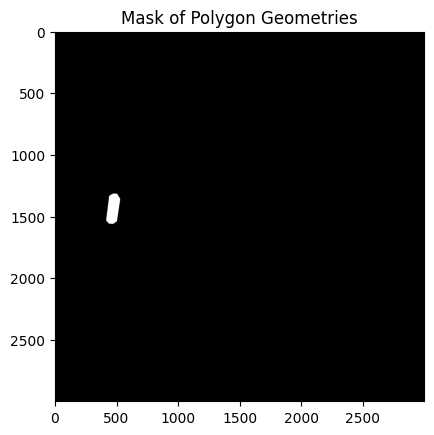

In [118]:
plt.imshow(car_mask, cmap='gray')
plt.title('Mask of Polygon Geometries')
plt.show()

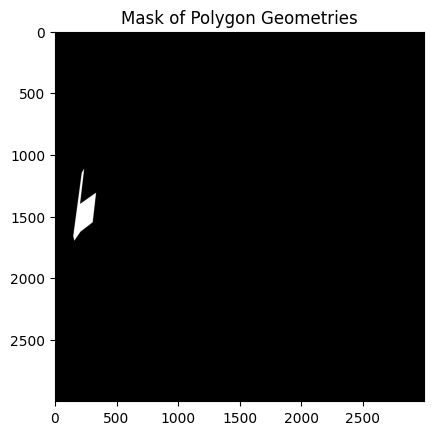

In [119]:
plt.imshow(truck_mask, cmap='gray')
plt.title('Mask of Polygon Geometries')
plt.show()

In [122]:
def split_image_to_tiles(image_path, mask, tile_width, tile_height, output_folder):
    # Open the image
    with Image.open(image_path) as img:
        image_width, image_height = img.size

        # Convert mask to PIL Image if it's not already
        if isinstance(mask, np.ndarray):
            mask = Image.fromarray(mask.astype(np.uint8) * 255)

        # Calculate the number of tiles in each dimension
        x_tiles = image_width // tile_width
        y_tiles = image_height // tile_height

        # Create output folder if it does not exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Generate tiles
        for x in range(x_tiles):
            for y in range(y_tiles):
                # Define the bounding box
                left = x * tile_width
                upper = y * tile_height
                right = (x + 1) * tile_width
                lower = (y + 1) * tile_height
                box = (left, upper, right, lower)

                # Crop the image to the bounding box
                tile = img.crop(box)

                # Crop the mask to the bounding box
                mask_tile = mask.crop(box)

                # Check if the tile contains any "true" values in the mask
                if np.any(mask_tile):
                    # Save the tile
                    tile.save(os.path.join(output_folder, f"tile_{x}_{y}.png"))

In [123]:
output_folder = f"/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/{test_id_rest}_{test_name}"

split_image_to_tiles(image_path=file_path_tif, mask=truck_mask, tile_width=500, tile_height=500, output_folder=output_folder)

In [ ]:

split_image_to_tiles(image_path='image.jpg', mask=Image.open(mask_path), tile_width=100, tile_height=100, output_folder='tiles')

### Graveyard

In [71]:
# Assuming gdf is your GeoDataFrame
gdf = parking_areas

# Define your bounding box [left, bottom, right, top]
bbox = test_bbox

# Calculate pixel size
width = height = 3000
xres = (bbox[2] - bbox[0]) / width
yres = (bbox[3] - bbox[1]) / height

# Create an affine transform for the raster
transform = rasterio.transform.from_bounds(*bbox, width, height)

# Create the mask
geometries = gdf.geometry
mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=(height, width))# Load the satellite image
with rasterio.open(file_path_tif) as src:
    data = src.read()
    if data.shape[0] == 3:
        satellite_image = np.moveaxis(data, 0, -1)
    else:
        raise ValueError("The image does not have 3 bands. Check your image data.")

    # Plot the figure with the desired DPI
    dpi = 600  # 3000 pixels / 10 inches
    fig, ax = plt.subplots(figsize=(5, 5), frameon=False, dpi=dpi)

    # Show the satellite image
    show(src, ax=ax)

    # Reproject the GeoDataFrame if necessary
    if parking_areas.crs != src.crs:
        parking_areas = parking_areas.to_crs(src.crs)

    # Plot the polygons
    parking_areas.plot(ax=ax, facecolor='none', edgecolor='red')

    # Remove axis and layout padding
    ax.axis('off')
    plt.tight_layout(pad=0)

    # Save the figure
    #plt.savefig("/content/drive/MyDrive/output_image.png", bbox_inches='tight', pad_inches=0)

    # Display the plot
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [72]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

with rasterio.open(file_path_tif) as src:
    data = src.read()
    if data.shape[0] == 3:
        satellite_image = np.moveaxis(data, 0, -1)
    else:
        raise ValueError("The image does not have 3 bands. Check your image data.")

    # Set the figure size and DPI for 3000x3000 pixels output
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    canvas = FigureCanvas(fig)

    # Show the satellite image using imshow
    ax.imshow(satellite_image)

    # Remove axis and layout padding
    ax.axis('off')
    plt.tight_layout(pad=0)

    # Draw the figure in memory
    canvas.draw()

    # Convert the figure to a numpy array
    image_array = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image_array = image_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Now, image_array is your 3000x3000 numpy array of the combined image

Output hidden; open in https://colab.research.google.com to view.

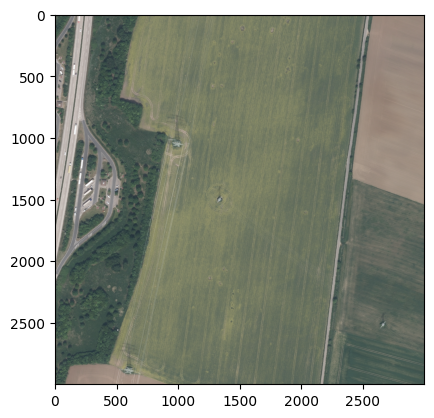

In [73]:
plt.imshow(image_array, cmap='gray')

In [209]:
# save as png

image = Image.fromarray(np.uint8(image_array))

# Save the image
#image.save("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/pngfromarray.png")

In [79]:
def split_image_to_tiles(image_path, tile_width, tile_height, output_folder):
    # Open the image
    with Image.open(image_path) as img:
        image_width, image_height = img.size

        # Calculate the number of tiles in each dimension
        x_tiles = image_width // tile_width
        y_tiles = image_height // tile_height

        # Create output folder if it does not exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Generate tiles
        for x in range(x_tiles):
            for y in range(y_tiles):
                # Define the bounding box
                left = x * tile_width
                upper = y * tile_height
                right = (x + 1) * tile_width
                lower = (y + 1) * tile_height
                box = (left, upper, right, lower)

                # Crop the image to the bounding box
                tile = img.crop(box)

                # Save the tile
                tile.save(os.path.join(output_folder, f"tile_{x}_{y}.png"))

In [80]:
# Usage
image_path = file_path_tif
tile_width = 500
tile_height = 500
output_folder = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Test Download PNG/Test Download tiles"
split_image_to_tiles(image_path, tile_width, tile_height, output_folder)

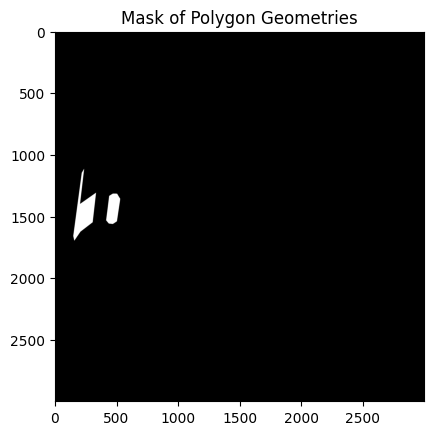

In [101]:
# Assuming gdf is your GeoDataFrame
gdf = parking_areas

# Define your bounding box [left, bottom, right, top]
bbox = test_bbox

# Calculate pixel size
width = height = 3000
xres = (bbox[2] - bbox[0]) / width
yres = (bbox[3] - bbox[1]) / height

# Create an affine transform for the raster
transform = rasterio.transform.from_bounds(*bbox, width, height)

# Create the mask
geometries = gdf.geometry
mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=(height, width))

# The mask is a numpy array that can be used for further processing

plt.imshow(mask, cmap='gray')
plt.title('Mask of Polygon Geometries')
plt.show()

In [61]:
mask.shape

(3000, 3000)